In [1]:
import time
from matplotlib import pyplot
#time.sleep(0.1)
from sklearn.preprocessing import LabelEncoder
#time.sleep(0.1)
from pandas import read_csv

1.大気汚染予測
このチュートリアルでは、大気質データセットを使用します。

これは、中国の北京にある米国大使館での5年間、1時間ごとの天気と汚染レベルを報告するデータセットです。

データには、日時、PM2.5濃度と呼ばれる汚染、露点、温度、圧力、風向、風速、雪と雨の累積時間数などの気象情報が含まれます。生データの完全な機能リストは次のとおりです。

いいえ：行番号
年：この行のデータの年
月：この行のデータの月
日：この行のデータの日
時間：この行のデータの時間
pm2.5：PM2.5濃度
DEWP：露点
TEMP：温度
PRES：圧力
cbwd：複合風向
Iws：累積風速
は：積雪時間
Ir：累積雨時間
このデータを使用して、前の時間の気象条件と汚染を考慮して、次の時間の汚染を予測する予測問題を組み立てることができます。
データセットをダウンロードし、ファイル名「raw.csv」で現在の作業ディレクトリに配置します。
最初のステップは、日時情報を単一の日時に統合して、パンダのインデックスとして使用できるようにすることです。

クイックチェックにより、最初の24時間のpm2.5のNA値が明らかになります。したがって、データの最初の行を削除する必要があります。データセットの後半には、散在する「NA」値もいくつかあります。今のところ、0の値でマークすることができます。

以下のスクリプトは、生のデータセットをロードし、日時情報をPandasDataFrameインデックスとして解析します。「いいえ」列が削除され、各列に明確な名前が指定されます。最後に、NA値が「0」値に置き換えられ、最初の24時間が削除されます。

「いいえ」列が削除され、各列に明確な名前が指定されます。最後に、NA値が「0」値に置き換えられ、最初の24時間が削除されます。

In [2]:
#import gc
#from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('./data/DT_merge_2000000_ffill_12columns.csv',index_col=0)#,
                   #parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
#dataset.drop('No', axis=1, inplace=True)
# manually specify column names
#dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'dt'
# mark all NA values with 0
#dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset)#.head(10))
# save to file
#dataset.to_csv('pollution.csv')
#gc.collect()

                EURJPYOPEN  EURJPYHIGH  EURJPYLOW  EURJPYCLOSE  EURUSDOPEN  \
dt                                                                           
2017/3/14 2:40      122.33      122.33     122.33       122.33      1.0654   
2017/3/14 2:41      122.34      122.34     122.34       122.34      1.0654   
2017/3/14 2:42      122.34      122.34     122.34       122.34      1.0654   
2017/3/14 2:43      122.34      122.34     122.34       122.34      1.0653   
2017/3/14 2:44      122.33      122.33     122.33       122.33      1.0653   
...                    ...         ...        ...          ...         ...   
2019/3/12 6:50      125.28      125.28     125.28       125.28      1.1258   
2019/3/12 6:51      125.27      125.27     125.27       125.27      1.1257   
2019/3/12 6:52      125.28      125.28     125.28       125.28      1.1258   
2019/3/12 6:53      125.28      125.28     125.28       125.28      1.1258   
2019/3/12 6:54      125.28      125.28     125.28       125.28  

例を実行すると、変換されたデータセットの最初の5行が出力され、データセットが「pollution.csv」に保存されます。
使いやすい形式のデータが得られたので、各シリーズのクイックプロットを作成して、データが何であるかを確認できます。

以下のコードは、新しい「pollution.csv」ファイルをロードし、カテゴリ別の風速dirを除いて、各シリーズを個別のサブプロットとしてプロットします。
例を実行すると、各変数の5年間のデータを示す7つのサブプロットを含むプロットが作成されます。

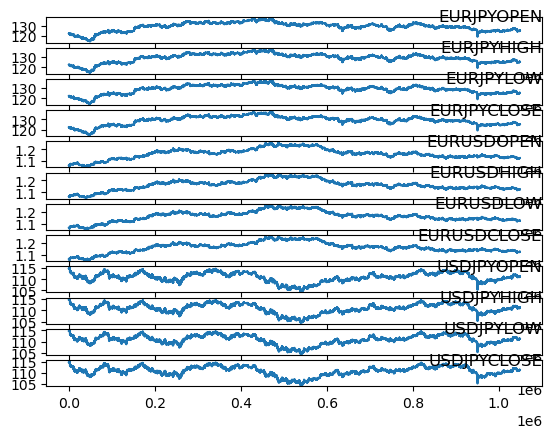

In [3]:
#import matplotlib
#from pandas import read_csv
#from matplotlib import pyplot
# load dataset
#dataset = read_csv('./data/DT_merge_2000000_ffill_12columns.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
#gc.collect()

3.多変量LSTM予測モデル
このセクションでは、LSTMを問題に適合させます。

LSTMデータの準備
最初のステップは、LSTMの汚染データセットを準備することです。

これには、データセットを教師あり学習問題としてフレーミングし、入力変数を正規化することが含まれます。

前のタイムステップでの汚染測定と気象条件を考慮して、現在の時間（t）での汚染を予測するものとして教師あり学習問題を組み立てます。

この定式化は単純で、このデモンストレーションのためだけのものです。あなたが探求することができるいくつかの代替処方は以下を含みます：

過去24時間の気象条件と汚染に基づいて、次の1時間の汚染を予測します。
上記のように次の1時間の汚染を予測し、次の1時間の「予想される」気象条件を考慮します。
ブログ投稿で開発されたseries_to_supervised（）関数を使用して、データセットを変換できます。

まず、「pollution.csv」データセットが読み込まれます。風向機能はラベルエンコード（整数エンコード）されています。あなたがそれを探求することに興味があるなら、これは将来さらにワンホットエンコードされるかもしれません。

次に、すべての特徴が正規化され、データセットが教師あり学習問題に変換されます。次に、予測される時間（t）の気象変数が削除されます。

完全なコードリストを以下に示します。

例を実行すると、変換されたデータセットの最初の5行が出力されます。8つの入力変数（入力系列）と1つの出力変数（現在の時間の汚染レベル）を確認できます。

In [4]:
#import time
# prepare data for lstm
#import sklearn
#from pandas import read_csv
from pandas import DataFrame
from pandas import concat
#time.sleep(1)
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
dataset

,EURJPYOPEN,EURJPYHIGH,EURJPYLOW,EURJPYCLOSE,EURUSDOPEN,EURUSDHIGH,EURUSDLOW,EURUSDCLOSE,USDJPYOPEN,USDJPYHIGH,USDJPYLOW,USDJPYCLOSE
dt,,,,,,,,,,,,
2017/3/14 2:40,122.33,122.33,122.33,122.33,1.0654,1.0654,1.0654,1.0654,114.80,114.80,114.80,114.80
2017/3/14 2:41,122.34,122.34,122.34,122.34,1.0654,1.0654,1.0654,1.0654,114.81,114.81,114.81,114.81
2017/3/14 2:42,122.34,122.34,122.34,122.34,1.0654,1.0654,1.0654,1.0654,114.81,114.81,114.81,114.81
2017/3/14 2:43,122.34,122.34,122.34,122.34,1.0653,1.0653,1.0653,1.0653,114.81,114.81,114.81,114.81
2017/3/14 2:44,122.33,122.33,122.33,122.33,1.0653,1.0653,1.0653,1.0653,114.81,114.81,114.81,114.81
...,...,...,...,...,...,...,...,...,...,...,...,...
2019/3/12 6:50,125.28,125.28,125.28,125.28,1.1258,1.1258,1.1258,1.1258,111.27,111.27,111.27,111.27
2019/3/12 6:51,125.27,125.27,125.27,125.27,1.1257,1.1257,1.1257,1.1257,111.26,111.26,111.26,111.26
2019/3/12 6:52,125.28,125.28,125.28,125.28,1.1258,1.1258,1.1258,1.1258,111.26,111.26,111.26,111.26


In [6]:
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
#values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
#values[:,4]

In [7]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.330977,0.330977,0.330977,0.330977,0.042864,0.042864,0.042864,0.042864,0.965714,0.965714,...,0.331419,0.331419,0.042864,0.042864,0.042864,0.042864,0.966666,0.966666,0.966761,0.966698
2,0.331419,0.331419,0.331419,0.331419,0.042864,0.042864,0.042864,0.042864,0.966666,0.966666,...,0.331419,0.331419,0.042864,0.042864,0.042864,0.042864,0.966666,0.966666,0.966761,0.966698
3,0.331419,0.331419,0.331419,0.331419,0.042864,0.042864,0.042864,0.042864,0.966666,0.966666,...,0.331419,0.331419,0.042360,0.042360,0.042360,0.042360,0.966666,0.966666,0.966761,0.966698
4,0.331419,0.331419,0.331419,0.331419,0.042360,0.042360,0.042360,0.042360,0.966666,0.966666,...,0.330977,0.330977,0.042360,0.042360,0.042360,0.042360,0.966666,0.966666,0.966761,0.966698
5,0.330977,0.330977,0.330977,0.330977,0.042360,0.042360,0.042360,0.042360,0.966666,0.966666,...,0.331419,0.331419,0.042864,0.042864,0.042864,0.042864,0.966666,0.966666,0.966761,0.966698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,0.461335,0.461335,0.461335,0.461335,0.347453,0.347453,0.347453,0.347453,0.629523,0.629523,...,0.461335,0.461335,0.347453,0.347453,0.347453,0.347453,0.629523,0.629523,0.630579,0.629876
1048571,0.461335,0.461335,0.461335,0.461335,0.347453,0.347453,0.347453,0.347453,0.629523,0.629523,...,0.460893,0.460893,0.346949,0.346949,0.346949,0.346949,0.628571,0.628571,0.629629,0.628924
1048572,0.460893,0.460893,0.460893,0.460893,0.346949,0.346949,0.346949,0.346949,0.628571,0.628571,...,0.461335,0.461335,0.347453,0.347453,0.347453,0.347453,0.628571,0.628571,0.629629,0.628924
1048573,0.461335,0.461335,0.461335,0.461335,0.347453,0.347453,0.347453,0.347453,0.628571,0.628571,...,0.461335,0.461335,0.347453,0.347453,0.347453,0.347453,0.629523,0.629523,0.630579,0.629876


In [8]:
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.drop(reframed.columns[[12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)
print(reframed)#.head(10))
#gc.collect()

         var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1         0.330977   0.330977   0.330977   0.330977   0.042864   0.042864   
2         0.331419   0.331419   0.331419   0.331419   0.042864   0.042864   
3         0.331419   0.331419   0.331419   0.331419   0.042864   0.042864   
4         0.331419   0.331419   0.331419   0.331419   0.042360   0.042360   
5         0.330977   0.330977   0.330977   0.330977   0.042360   0.042360   
...            ...        ...        ...        ...        ...        ...   
1048570   0.461335   0.461335   0.461335   0.461335   0.347453   0.347453   
1048571   0.461335   0.461335   0.461335   0.461335   0.347453   0.347453   
1048572   0.460893   0.460893   0.460893   0.460893   0.346949   0.346949   
1048573   0.461335   0.461335   0.461335   0.461335   0.347453   0.347453   
1048574   0.461335   0.461335   0.461335   0.461335   0.347453   0.347453   

         var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1

このデータの準備は簡単で、さらに調査できることがあります。あなたが見ることができるいくつかのアイデアは次のとおりです。

ワンホットエンコーディングの風向。
差異調整と季節調整により、すべてのシリーズを静止させます。
1時間以上の入力タイムステップを提供します。
この最後の点は、シーケンス予測の問題を学習するときにLSTMによる時間による逆伝播の使用を考えると、おそらく最も重要です。

モデルの定義と適合
このセクションでは、多変量入力データにLSTMを適合させます。

まず、準備したデータセットをトレーニングセットとテストセットに分割する必要があります。このデモンストレーションのモデルのトレーニングを高速化するために、モデルを最初の1年のデータにのみ適合させ、残りの4年のデータで評価します。時間がある場合は、このテストハーネスの反転バージョンを検討することを検討してください。

以下の例では、データセットをトレインセットとテストセットに分割してから、トレインセットとテストセットを入力変数と出力変数に分割します。最後に、入力（X）は、LSTMが期待する3D形式、つまり[サンプル、タイムステップ、機能]に再形成されます。

この例を実行すると、トレーニング用に約9K時間、テスト用に約35K時間のデータを含む、トレインとテストの入力および出力セットの形状が印刷されます。

In [9]:
...
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
n_train_hours = 365 * 24 * 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(525600, 1, 12) (525600,) (522974, 1, 12) (522974,)


これで、LSTMモデルを定義して適合させることができます。

汚染を予測するために、最初の隠れ層に50個のニューロン、出力層に1個のニューロンを持つLSTMを定義します。入力形状は、8つの特徴を持つ1つのタイムステップになります。

平均絶対誤差（MAE）損失関数と、確率的勾配降下法の効率的なアダムバージョンを使用します。

モデルは、バッチサイズ72の50トレーニングエポックに適合します。KerasのLSTMの内部状態は各バッチの終了時にリセットされるため、日数の関数である内部状態は次のようになる可能性があることに注意してください。役に立ちました（これをテストしてみてください）。

最後に、fit（）関数でvalidation_data引数を設定することにより、トレーニング中のトレーニングとテストの損失の両方を追跡します。実行の最後に、トレーニングとテストの両方の損失がプロットされます。

In [10]:
import tensorflow
#テストプログラムでFunction call stack: train_functionが出たときに
#検索したコード。先頭に入れる
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [11]:
from tensorflow.keras.models import Sequential

In [12]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

Epoch 1/20
7300/7300 - 35s - loss: 0.0138 - val_loss: 0.2980
Epoch 2/20
7300/7300 - 26s - loss: 0.0098 - val_loss: 0.2043
Epoch 3/20
7300/7300 - 27s - loss: 0.0077 - val_loss: 0.1456
Epoch 4/20
7300/7300 - 26s - loss: 0.0067 - val_loss: 0.1193
Epoch 5/20
7300/7300 - 26s - loss: 0.0057 - val_loss: 0.0759
Epoch 6/20
7300/7300 - 26s - loss: 0.0051 - val_loss: 0.0664
Epoch 7/20
7300/7300 - 25s - loss: 0.0048 - val_loss: 0.0493
Epoch 8/20
7300/7300 - 26s - loss: 0.0046 - val_loss: 0.0396
Epoch 9/20
7300/7300 - 27s - loss: 0.0042 - val_loss: 0.0328
Epoch 10/20
7300/7300 - 27s - loss: 0.0042 - val_loss: 0.0314
Epoch 11/20
7300/7300 - 26s - loss: 0.0040 - val_loss: 0.0282
Epoch 12/20
7300/7300 - 26s - loss: 0.0040 - val_loss: 0.0259
Epoch 13/20
7300/7300 - 26s - loss: 0.0040 - val_loss: 0.0245
Epoch 14/20
7300/7300 - 26s - loss: 0.0039 - val_loss: 0.0233
Epoch 15/20
7300/7300 - 26s - loss: 0.0038 - val_loss: 0.0225
Epoch 16/20
7300/7300 - 26s - loss: 0.0039 - val_loss: 0.0236
Epoch 17/20
7300/

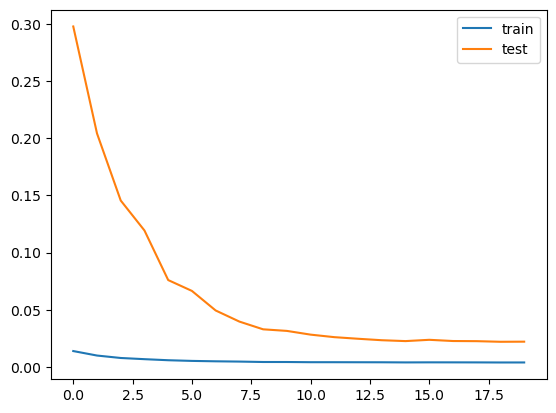

In [13]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

モデルの評価
モデルが適合した後、テストデータセット全体を予測できます。

予測をテストデータセットと組み合わせて、スケーリングを反転します。また、予想される汚染数を使用して、テストデータセットのスケーリングを反転します。

予測と実際の値を元のスケールで使用して、モデルのエラースコアを計算できます。この場合、変数自体と同じ単位で誤差を与える二乗平均平方根誤差（RMSE）を計算します。

In [14]:
from tensorflow.keras.layers import concatenate
#model_from_json(model_file, custom_objects={'concatenate': concatenate})

In [15]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM

In [16]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.650


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Epoch 1/50
122/122 - 2s - loss: 0.0547 - val_loss: 0.0528
Epoch 2/50
122/122 - 1s - loss: 0.0331 - val_loss: 0.0517
Epoch 3/50
122/122 - 1s - loss: 0.0193 - val_loss: 0.0434
Epoch 4/50
122/122 - 1s - loss: 0.0158 - val_loss: 0.0249
Epoch 5/50
122/122 - 1s - loss: 0.0150 - val_loss: 0.0187
Epoch 6/50
122/122 - 1s

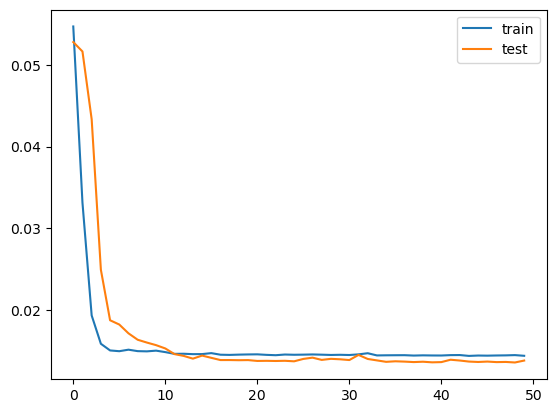

Test RMSE: 26.746


In [17]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

複数のラグタイムステップの例でトレーニングする
上記の例を適応させて、以前の複数のタイムステップでモデルをトレーニングする方法について、アドバイスを求める声が多く寄せられています。

私は元の投稿を書くときにこれと他の無数の構成を試しましたが、モデルのスキルを向上させなかったため、それらを含めないことにしました。

それでも、この例を、独自の問題に適応できる参照テンプレートとして以下に含めました。

次のように、以前の複数のタイムステップでモデルをトレーニングするために必要な変更はごくわずかです。

まず、series_to_supervised（）を呼び出すときに、問題を適切にフレーム化する必要があります。3時間のデータを入力として使用します。また、ob（t）で他のすべてのフィールドから列を明示的に削除しなくなったことにも注意してください。

次に、入力と出力の列を指定する際に、より注意する必要があります。

フレーム化されたデータセットには3 * 8 +8列があります。過去3時間のすべての機能のobsの入力として、3 * 8または24列を使用します。次のように、次の時間の出力として汚染変数のみを取得します。

次に、時間ステップと特徴を反映するように入力データを正しく再形成できます。

モデルのフィッティングも同じです。

他の小さな変更は、モデルの評価方法だけです。具体的には、スケーリング操作を逆にしてyとyhatを元のスケールに戻し、RMSEを計算できるようにするのに適した、8列の行を再構築する方法について説明します。

変更の要点は、次のように、スケーリングを逆にするために、yまたはyhat列をテストデータセットの最後の7つの機能と連結することです。

これらの変更をすべて上記の例に結び付けることができます。複数のラグ入力を使用した多変量時系列予測の完全な例を以下に示します。

(43797, 32)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Epoch 1/50
122/122 - 2s - loss: 0.0412 - val_loss: 0.0671
Epoch 2/50
122/122 - 1s - loss: 0.0251 - val_loss: 0.0433
Epoch 3/50
122/122 - 1s - loss: 0.0210 - val_loss: 0.0293
Epoch 4/50
122/122 - 1s - loss: 0.0204 - val_loss: 0.0278
Epoch 5/50
122/122 - 1s - loss: 0.0199 - val_loss: 0.0243
Epoch 6/50
122/122 - 1s - loss: 0.0196 - val_loss: 0.0227
Epoch 7/50
122/122 - 1s - loss: 0.0193 - val_loss: 0.0201
Epoch 8/50
122/122 - 1s - loss: 0.0188 - val_loss: 0.0196
Epoch 9/50
122/122 - 1s - loss: 0.0183 - val_loss: 0.0189
Epoch 10/50
122/122 - 1s - loss: 0.0179 - val_loss: 0.0185
Epoch 11/50
122/122 - 1s - loss: 0.0174 - val_loss: 0.0187
Epoch 12/50
122/122 - 1s - loss: 0.0171 - val_loss: 0.0181
Epoch 13/50
122/122 - 1s - loss: 0.0167 - val_loss: 0.0191
Epoch 14/50
122/122 - 1s - loss: 0.0164 - val_loss: 0.0192
Epoch 15/50
122/122 - 1s - loss: 0.0159 - val_loss: 0.0186
Epoch 16/50
122/122 - 1s - loss: 0.0155 - va

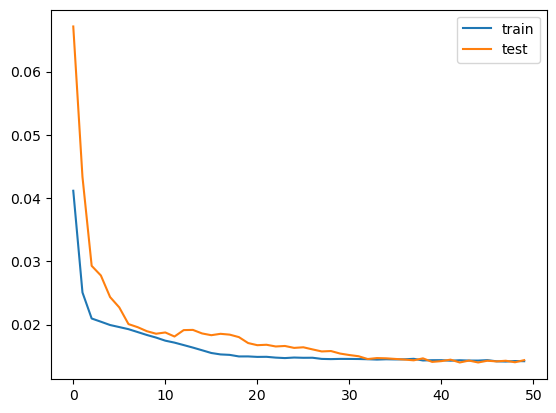

Test RMSE: 26.742


In [19]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)